<a href="https://colab.research.google.com/github/zainuamalik/Facial-Features-Detector/blob/main/Facial_Feature_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting google drive to access files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers

In [ ]:
# Getting files from drive

train_data = np.load('/content/drive/MyDrive/Face Alignment/New/training_images.npz', allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/Face Alignment/New/test_images.npz', allow_pickle=True)
example_data = np.load('/content/drive/MyDrive/Face Alignment/New/examples.npz', allow_pickle=True)

print('Data downloaded')

Data downloaded


In [ ]:
# Extracting the training images and data points

images = train_data['images']

pts = train_data['points']

# Printing shapes of the arrays

print('Training Images Shape: ' + str(images.shape))
print('Keypoints Shape: ' + str(pts.shape))

# Extracting the testing images

test_images = test_data['images']

example_images= example_data['images']

# Printing shape of the array

print('Testing Images Shape: ' + str(test_images.shape))
print('Example Images Shape: ' + str(example_images.shape))

Training Images Shape: (2811, 242, 242, 3)
Keypoints Shape: (2811, 32, 2)
Testing Images Shape: (554, 242, 242, 3)
Example Images Shape: (6, 242, 242, 3)


In [ ]:
# Helper functions #

# Convert images to greyscale

def convert_to_grey(images):
  grey_images= []
  for image in images:
    new_img= cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    grey_images.append(new_img)

  return np.array(grey_images)

# Function to visualise points on an image

def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

In [ ]:
# Select first 1000 images and corresponding keypoints
X_train = images[:1000, :]
y_train = pts[:1000, :]

# Select 200 images and corresponding keypoints after the 1000 mark
X_val = images[1000:1200, :]
y_val= pts[1000:1200, :]

# Divide the image data to put it in the right range and convert to floating point numbers

X_train = X_train.astype("float32") / 255
X_val = X_val.astype("float32") / 255
X_test= test_images.astype("float32") / 255
example_images= example_images.astype("float32") / 255

# Convert the labels to floating point

y_train = y_train.astype("float32")
y_val = y_val.astype("float32")

# Reshape keypoints array into single dimension
y_train= y_train.reshape(-1, 32*2)
y_val= y_val.reshape(-1, 32*2)

In [ ]:
#################################
# CNN Architecture and Model Training

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

model= Sequential()

model.add(Convolution2D(256, (3,3), strides= 2, input_shape= (242,242,3)))

model.add(Convolution2D(256, (3,3),  strides=2, activation='relu'))

model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3), strides= 1, activation='relu'))
model.add(Convolution2D(128, (3,3),  strides= 1, activation='relu'))

model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3), strides= 1, activation='relu'))
model.add(Convolution2D(128, (3,3), strides= 1, activation='relu'))

model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), strides= 1, activation='relu'))
model.add(Convolution2D(64, (3,3), strides= 1, activation='relu'))
model.add(Convolution2D(64, (3,3), strides= 1))

model.add(Flatten())
model.add(Dense(64))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics= ['accuracy'])

In [ ]:
history=model.fit(X_train, y_train, epochs= 10, batch_size= 100, validation_data=(X_val, y_val))

In [ ]:
model.save('/content/drive/MyDrive/Face Alignment/New/Models/h10100l40a71.h5')

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Face Alignment/New/Models/h10100l40a71.h5')

In [ ]:
# Predict facial landmarks for example images

ex_pred= model.predict(example_images)
ex_pred= ex_pred.reshape(-1, 32, 2)

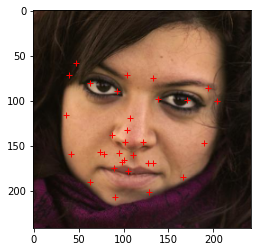

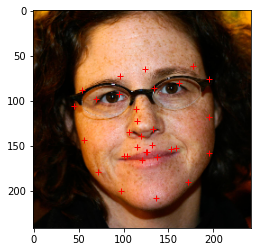

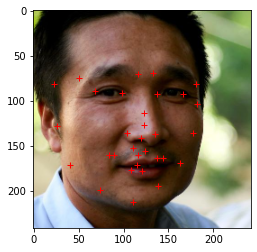

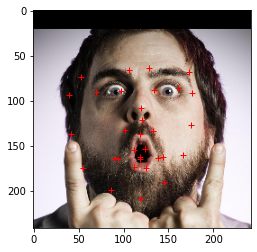

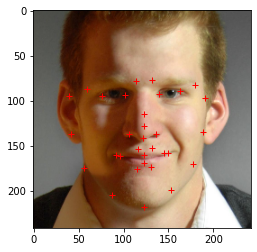

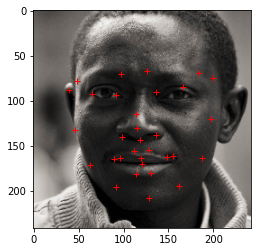

In [ ]:
# Visualise example images with face landmarks

for i in range(6):
  visualise_pts(example_images[i], ex_pred[i])

In [ ]:
train_pred= model.predict(X_train)
train_pred= train_pred.reshape(-1, 32, 2)

In [ ]:
##########################################

In [ ]:
#PREDCITION ERROR
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

eu_dist= euclid_dist(train_pred, pts[:1000])

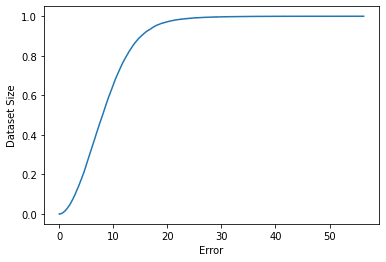

In [ ]:
#Graph to visualise the cumulative error distribution
plt.step(np.sort(eu_dist), np.linspace(0, 1, len(data)))
plt.ylabel('Dataset Size')
plt.xlabel('Error')
plt.show()

In [ ]:
scores= model.evaluate(X_train, y_train)

32/32 [==============================] - 160s 5s/step - loss: 50.8623 - acc: 0.8650


In [ ]:
print("Loss: " + str(scores[0]))

print("Accuracy: " + str(scores[1]))

Loss: 50.8622932434082
Accuracy: 0.8650000095367432


In [ ]:
# Get predictions for test images
predictions= model.predict(X_test)
predictions= predictions.reshape(-1, 32, 2)

In [ ]:
#EXPORT OF RESULTS
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
save_as_csv(predictions, '/content/drive/MyDrive/Face Alignment/New/FINAL')